In [2]:
from ipywidgets import interact, widgets
import cv2
import os
import mediapipe as mp
from google.protobuf.json_format import MessageToDict
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils.class_weight import compute_class_weight

Using TensorFlow backend.


<h1>Creating the dataset</h1>

In [3]:
# visualize and input the data capture chord name
print("Select the chord you want to capture?")
chord_option = widgets.Dropdown(
 options=["C","D", "E","F","G","A","B", "Em", "Fm", "Cm"],
 value = "C",
 description="Chord"
 )
# Check whether user wants to clean or append data
clean_current_chord_data = widgets.Checkbox(
    value=False,
    description="Clean existing image data? ",
    disabled=False,
    indent=False
)

display(chord_option)
display(clean_current_chord_data)

Select the chord you want to capture?


Dropdown(description='Chord', options=('C', 'D', 'E', 'F', 'G', 'A', 'B', 'Em', 'Fm', 'Cm'), value='C')

Checkbox(value=False, description='Clean existing image data? ', indent=False)

In [4]:
print("You will capture data for the " + chord_option.value + " chord.")
print("Clean up existing training data: " + str(clean_current_chord_data.value))

You will capture data for the C chord.
Clean up existing training data: False


In [5]:
chordName = chord_option.value
# cleanup = clean_current_chord_data.value
chord_legend = cv2.imread("CaptureLabel/%s.jpg" % chordName, cv2.IMREAD_COLOR)

# The little square showing the current chord will be 80 x 80
legend_size = 80
W = 640
center_column = W // 2 - legend_size // 2


mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

image_x, image_y = 200, 200

def create_folder(folder_name):
    if not os.path.exists(folder_name):
        os.mkdir(folder_name)
        
# keypoint_connections = [(0, 1), (0, 13), (1, 5), (5, 9), (9, 13), (1, 2), (2, 3), (3, 4), (5, 6),
#                         (6, 7), (7, 8), (9, 10), (10, 11), (11, 12), (13, 14), (14, 15), (15, 16)]

keypoint_connections = [(0, 4), (4, 8), (8, 12), (0, 1), (1, 2), (2, 3), (4, 5),
                        (5, 6), (6, 7), (8, 9), (9, 10), (10, 11), (12, 13), (13, 14), (14, 15)]

keypoint_color = (255, 255, 255)
line_color = (255, 255, 255)
        
total_pics = 2000
hands = mp_hands.Hands(
    min_detection_confidence=0.5, min_tracking_confidence=0.5)
# hand_landmark_drawing_spec = mp_drawing.DrawingSpec(thickness=5, circle_radius=5)
# hand_connection_drawing_spec = mp_drawing.DrawingSpec(thickness=10, circle_radius=10)
cap = cv2.VideoCapture(1)
create_folder("chords/" + str(chordName))
pic_no = 0
flag_start_capturing = False
frames = 0

while cap.isOpened():
    ret, image = cap.read()  
    if ret:
        img_y, img_x, _ = image.shape
        H,W,C = image.shape
        image = cv2.flip(image, 1)
        image_orig = cv2.flip(image, 1)
        image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        results_hand = hands.process(image)
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        if results_hand.multi_hand_landmarks:
            for hand_landmarks in results_hand.multi_hand_landmarks:
                landmarks = MessageToDict(hand_landmarks)["landmark"]
                # landmarks.pop(1)
                # landmarks.pop(2)
                # landmarks.pop(2)
                # landmarks.pop(1)
                landmarks.pop(0)
                landmarks.pop(0)
                landmarks.pop(1)
                landmarks.pop(1)
                landmarks.pop(0)
                decoded_landmarks = []
                
                for l in landmarks:
                    x, y = int(l['x'] * img_x), int(l['y'] * img_y)
                    decoded_landmarks.append({'x': x, 'y': y})

                for l in decoded_landmarks:
                    cv2.circle(image, (l['x'], l['y']), 5, keypoint_color, 5)

                for c in keypoint_connections:
                    cv2.line(image, (decoded_landmarks[c[0]]['x'], decoded_landmarks[c[0]]['y']),
                             (decoded_landmarks[c[1]]['x'], decoded_landmarks[c[1]]['y']), line_color, 10)
                    
        res = cv2.bitwise_and(image, cv2.bitwise_not(image_orig))

        gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
        ret, th1 = cv2.threshold(gray, 25, 255, cv2.THRESH_BINARY)
        contours, hierarchy = cv2.findContours(th1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if len(contours) > 0:
            contour = max(contours, key=cv2.contourArea)
            # if cv2.contourArea(contour) > 10000 and frames > 50:
            x1, y1, w1, h1 = cv2.boundingRect(contour)
            pic_no += 1
            cv2.rectangle(image, (x1, y1), (x1 + w1, y1 + h1), (0, 255, 0), 2)
            save_img = gray[y1:y1 + h1, x1:x1 + w1]
            save_img = cv2.resize(save_img, (image_x, image_y))
            image[0:legend_size, W - legend_size - center_column:W - legend_size - center_column + legend_size] = chord_legend
            cv2.putText(image, "Capturing", (30, 60), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 255), 2)
            cv2.imwrite("chords/" + str(chordName) + "/" + str(pic_no) + ".jpg", save_img)

            # cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(image, str(pic_no), (30, 400), cv2.FONT_HERSHEY_COMPLEX, 1.5, (127, 127, 255))
            keypress = cv2.waitKey(1)
            if keypress == ord('c'):
                if flag_start_capturing == False:
                    flag_start_capturing = True
                else:
                    flag_start_capturing = False
                    frames = 0
            if flag_start_capturing == True:
                frames += 1
            if pic_no == total_pics:
                break
        cv2.imshow("Capturing gesture", image)
        cv2.imshow("Res", res)
    else:
        break
        

In [3]:
import splitfolders  # or import split_folders

input_folder = 'chords/'

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
#Train, val, test
splitfolders.ratio(input_folder, output="dataSplit", 
                   seed=42, ratio=(.7, .2, .1), 
                   group_prefix=None) # default values


In [2]:
import tensorflow as tf; 
import keras;

print(keras.__version__)
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.3.1
2.1.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<h1> Building of Custom CNN Model </h1>

In [1]:
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator

image_x, image_y = 200, 200
batch_size = 32
# train_dir = "chords"

train_dir = 'dataset/train/'
validation_dir = 'dataset/val/'
testing_dir = 'dataset/test/'

Using TensorFlow backend.


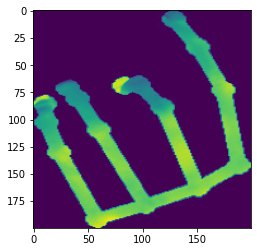

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('dataset/train/F/45.jpg')
imgplot = plt.imshow(img)
plt.show()

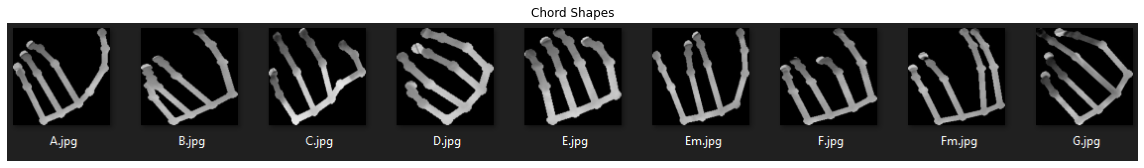

In [45]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

img = load_img('shapes.png')
plt.figure(figsize = (16,16))
plt.imshow(img)
plt.axis('off')
plt.title('Chord Shapes')
plt.show()

In [2]:
def keras_model(image_x, image_y):
    num_of_classes = 9
    model = Sequential()
    model.add(Conv2D(32, (5, 5), input_shape=(image_x, image_y, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(5, 5), strides=(5, 5), padding='same'))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.6))
    model.add(Dense(num_of_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    filepath = "latestModel.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]

    return model, callbacks_list

In [3]:
train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        rotation_range=15,
        zoom_range=0.2,
        horizontal_flip=False,
#         validation_split=0.2,
        fill_mode='nearest')

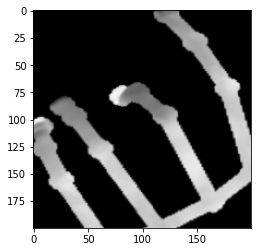

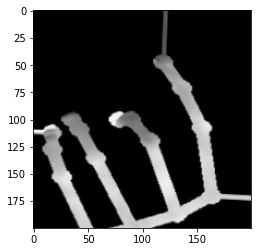

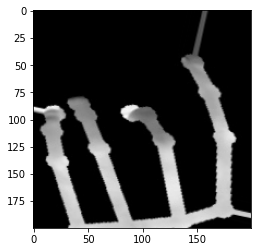

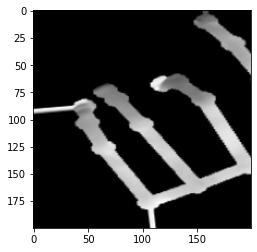

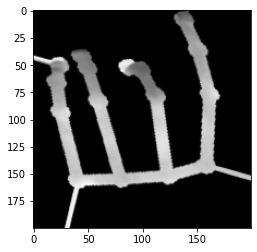

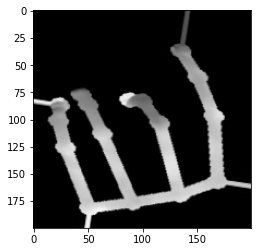

In [7]:
from tensorflow.keras.preprocessing import image

img_path = 'dataset/train/F/45.jpg'
img = image.load_img(img_path, target_size=(image_x, image_y))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0
for batch in train_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 6 == 0:
        break
plt.show()

In [4]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_x, image_y),
        color_mode="grayscale",
        batch_size=batch_size,
        seed=42,
        class_mode='categorical')

Found 12600 images belonging to 9 classes.


In [5]:
train_generator.class_indices

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'Em': 5, 'F': 6, 'Fm': 7, 'G': 8}

In [6]:
validation_datagen = ImageDataGenerator(rescale=1. / 255)

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_x, image_y),
        color_mode="grayscale",
        batch_size=batch_size,
        seed=42,
        class_mode='categorical')

Found 3600 images belonging to 9 classes.


In [7]:
testing_datagen = ImageDataGenerator(rescale=1. / 255)

testing_generator = testing_datagen.flow_from_directory(
        testing_dir,
        target_size=(image_x, image_y),
        color_mode="grayscale",
        batch_size=batch_size,
        seed=42,
        shuffle=False,
        class_mode='categorical')

Found 1800 images belonging to 9 classes.


In [12]:
# plt.rcParams.update({'font.size': 30})
cls_train = train_generator.classes
from collections import OrderedDict
classes = list(train_generator.class_indices.keys())
num_values = []
unique, counts = np.unique(cls_train, return_counts=True)
valdict=OrderedDict(zip(unique, counts))
for i in range(9):
    num_values.append(valdict[i])
plt.figure(figsize=(40,10))
x = np.arange(len(num_values))
xlabel = classes
plt.bar(x, num_values)
plt.xticks(x, xlabel)
plt.xticks(fontsize=28)
plt.show()   

NameError: name 'np' is not defined

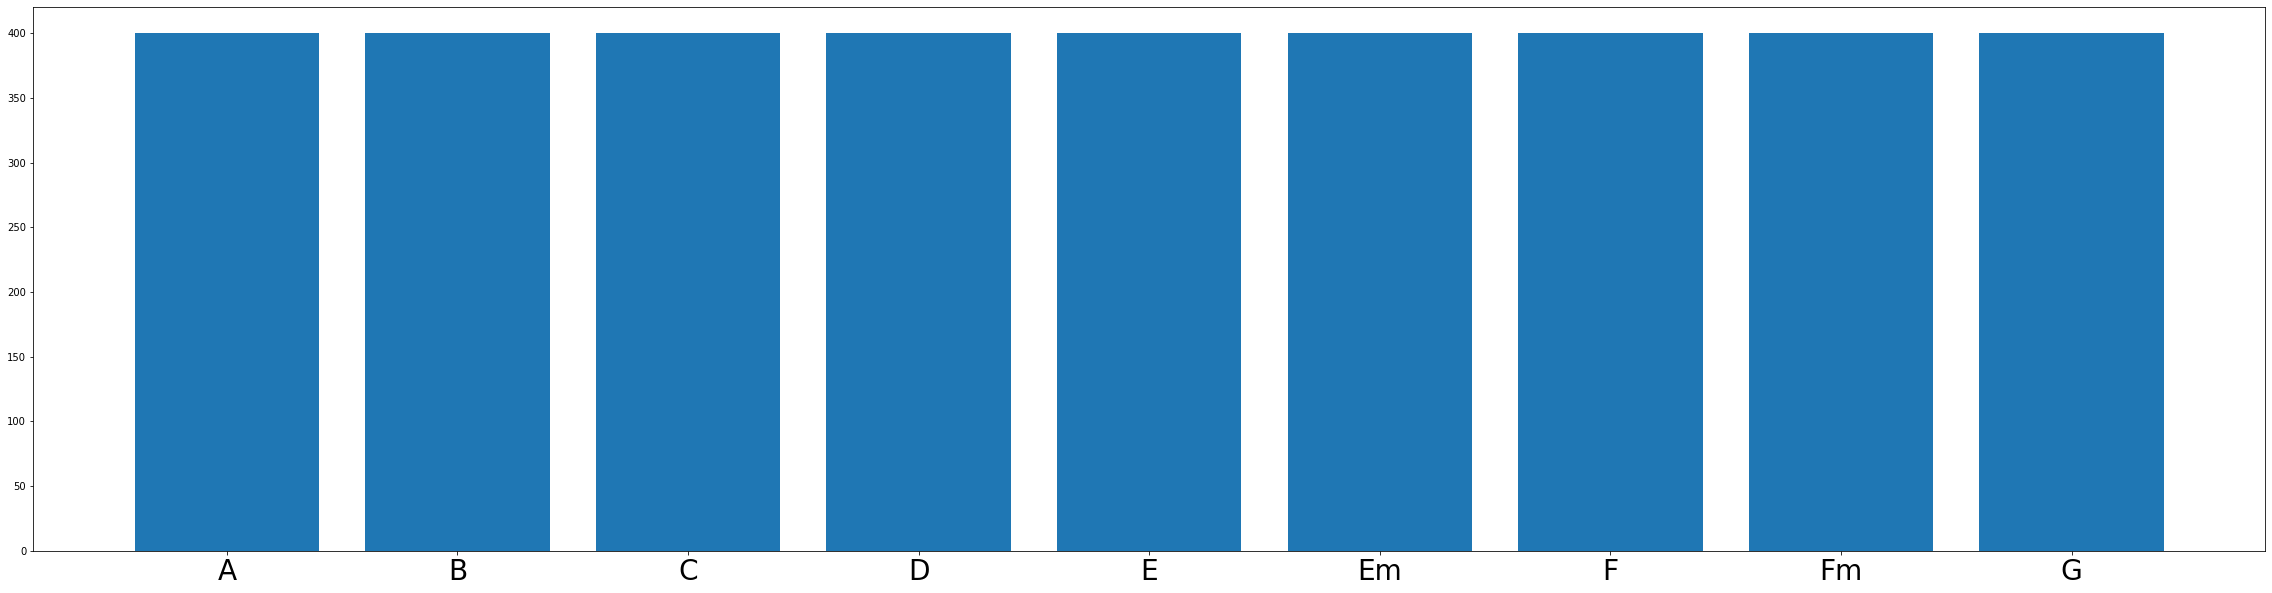

In [13]:
from sklearn.utils.class_weight import compute_class_weight
cls_test = validation_generator.classes
from collections import OrderedDict

# plt.rcParams.update({'font.size': 30})
classes = list(validation_generator.class_indices.keys())
num_values = []
unique, counts = np.unique(cls_test, return_counts=True)
valdict=OrderedDict(zip(unique, counts))
for i in range(9):
    num_values.append(valdict[i])
plt.figure(figsize=(40,10))
x = np.arange(len(num_values))
xlabel = classes
plt.bar(x, num_values)
plt.xticks(x, xlabel)
plt.xticks(fontsize=28)
plt.show() 

In [8]:
model, callbacks_list = keras_model(image_x, image_y)

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 196, 196, 32)      832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 94, 94, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 19, 19, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 23104)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              23659520  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)             

In [9]:
history = model.fit_generator(train_generator, epochs=5, validation_data=validation_generator)
scores = model.evaluate_generator(generator=validation_generator, steps=64)
print("CNN Error: %.2f%%" % (100 - scores[1] * 100))

model.save('5epoch.h5')

Epoch 1/5
394/394 [==============================] - 324s 823ms/step - loss: 0.9675 - accuracy: 0.6602 - val_loss: 0.0915 - val_accuracy: 0.9869
Epoch 2/5
394/394 [==============================] - 316s 801ms/step - loss: 0.3281 - accuracy: 0.8929 - val_loss: 0.0048 - val_accuracy: 0.9947
Epoch 3/5
394/394 [==============================] - 315s 800ms/step - loss: 0.2378 - accuracy: 0.9225 - val_loss: 0.0166 - val_accuracy: 0.9950
Epoch 4/5
394/394 [==============================] - 315s 800ms/step - loss: 0.1865 - accuracy: 0.9409 - val_loss: 0.0813 - val_accuracy: 0.9919
Epoch 5/5
394/394 [==============================] - 318s 807ms/step - loss: 0.1641 - accuracy: 0.9486 - val_loss: 0.0028 - val_accuracy: 0.9958
CNN Error: 0.44%


In [16]:
test_score = model.evaluate_generator(testing_generator, batch_size)

print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100)) 
print("[INFO] Loss: ",test_score[0])

[INFO] accuracy: 99.22%
[INFO] Loss:  0.00017149077029898763


In [27]:
train_generator.class_indices

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}

In [13]:
testing_generator.classes

array([0, 0, 0, ..., 8, 8, 8])

Confusion Matrix
Normalized confusion matrix
Classification Report
              precision    recall  f1-score   support

           A       1.00      0.97      0.98       200
           B       0.97      1.00      0.99       200
           C       1.00      1.00      1.00       200
           D       1.00      1.00      1.00       200
           E       1.00      1.00      1.00       200
          Em       1.00      1.00      1.00       200
           F       1.00      1.00      1.00       200
          Fm       1.00      1.00      1.00       200
           G       1.00      1.00      1.00       200

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



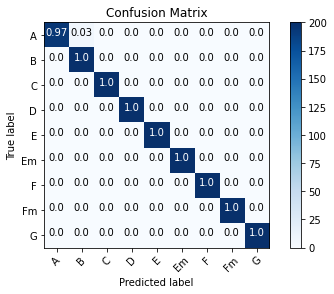

In [21]:
#Plot the confusion matrix. Set Normalize = True/False
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
#     plt.figure(figsize=(10,10))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Print the Target names
from sklearn.metrics import classification_report, confusion_matrix
import itertools 
#shuffle=False

target_names = []
for key in train_generator.class_indices:
    target_names.append(key)

# print(target_names)

#Confution Matrix 

Y_pred = model.predict_generator(testing_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(testing_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

#Print Classification Report
print('Classification Report')
print(classification_report(testing_generator.classes, y_pred, target_names=target_names))

Text(0.5, 1.0, 'Loss Curves')

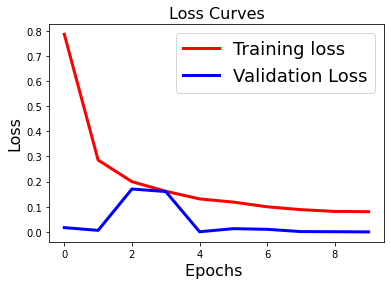

In [18]:
#Plot the Graph

# Loss Curves
# plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)


Text(0.5, 1.0, 'Accuracy Curves')

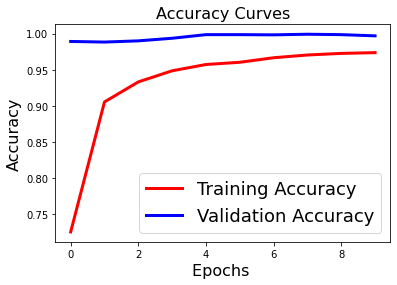

In [19]:
# Accuracy Curves
# plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

<h1>Building of InceptionV2 Model </h1>

In [1]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.python.keras.optimizers import Adam, RMSprop
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from numpy import loadtxt
import tensorflow.keras
from PIL import Image, ImageOps
%matplotlib inline

In [2]:
image_size = 256
batch_size = 32

In [3]:
# folders with train dir & val dir
train_dir = 'dataset/train/'
test_dir = 'dataset/val/'
testing_dir = 'dataset/test/'

input_shape = (image_size, image_size, 3)

In [4]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                              samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = True, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.2, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.2)

In [5]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical')

Found 12600 images belonging to 9 classes.


In [6]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical')

Found 3600 images belonging to 9 classes.


In [7]:
testing_datagen = ImageDataGenerator(rescale=1. / 255)

testing_generator = testing_datagen.flow_from_directory(
    testing_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical')

Found 1800 images belonging to 9 classes.


In [8]:
train_generator.class_indices

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'Em': 5, 'F': 6, 'Fm': 7, 'G': 8}

In [9]:
pretrained_model = InceptionV3(weights='imagenet', include_top=False)
pretrained_model.summary()

87916544/87910968 [==============================] - 25s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_____________________

In [10]:
pretrained_model.trainable = False
pretrained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [16]:
x = pretrained_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(512)(x)
x = Activation('relu')(x)
predictions = Dense(9, activation='softmax')(x)
model = Model(inputs=pretrained_model.input, outputs=predictions)

In [17]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [22]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

filepath="inceptionv3_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=10, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks_list = [checkpoint, learning_rate_reduction]

steps_per_epoch = 40
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=5,
    callbacks=callbacks_list,
    epochs=25,
    verbose=2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 40 steps, validate for 5 steps
Epoch 1/25

Epoch 00001: val_loss improved from inf to 12.39280, saving model to inceptionv3_model.h5
40/40 - 71s - loss: 0.3837 - accuracy: 0.8617 - val_loss: 12.3928 - val_accuracy: 0.2313
Epoch 2/25

Epoch 00002: val_loss improved from 12.39280 to 7.44494, saving model to inceptionv3_model.h5
40/40 - 65s - loss: 0.3847 - accuracy: 0.8781 - val_loss: 7.4449 - val_accuracy: 0.2000
Epoch 3/25

Epoch 00003: val_loss did not improve from 7.44494
40/40 - 64s - loss: 0.4144 - accuracy: 0.8656 - val_loss: 7.5807 - val_accuracy: 0.2313
Epoch 4/25

Epoch 00004: val_loss did not improve from 7.44494
40/40 - 64s - loss: 0.3432 - accuracy: 0.8883 - val_loss: 7.5892 - val_accuracy: 0.2438
Epoch 5/25

Epoch 00005: val_loss did not improve from 7.44494
40/40 - 64s - loss: 0.3274 - accuracy: 0.8820 - val_loss: 9.7905 - val_accuracy: 0.1500
Epoch 6/25

Epoch 00006: val_loss did not improve from 7.44494
40/40 - 

In [23]:
test_score = model.evaluate_generator(testing_generator, batch_size)

print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100)) 
print("[INFO] Loss: ",test_score[0])

  ...
    to  
  ['...']
[INFO] accuracy: 32.52%
[INFO] Loss:  5.318463094299659


<h1> Fine Tuning InceptionV3 </h1>

In [24]:
model.load_weights("inceptionv3_model.h5")

In [25]:
pretrained_model.trainable = False
for layer in model.layers[:290]:
   layer.trainable = False
for layer in model.layers[290:]:
   layer.trainable = True

In [26]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

filepath="inceptionv3_fine_tuned.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint, learning_rate_reduction]


steps_per_epoch = 32
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=5,
    callbacks=callbacks_list,
    epochs=10,
    verbose=2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 32 steps, validate for 5 steps
Epoch 1/10

Epoch 00001: val_loss improved from inf to 7.65275, saving model to inceptionv3_fine_tuned.h5
32/32 - 61s - loss: 0.6115 - accuracy: 0.8301 - val_loss: 7.6527 - val_accuracy: 0.2000
Epoch 2/10

Epoch 00002: val_loss improved from 7.65275 to 5.61381, saving model to inceptionv3_fine_tuned.h5
32/32 - 55s - loss: 0.4175 - accuracy: 0.8799 - val_loss: 5.6138 - val_accuracy: 0.1688
Epoch 3/10

Epoch 00003: val_loss did not improve from 5.61381
32/32 - 54s - loss: 0.3257 - accuracy: 0.8936 - val_loss: 6.7385 - val_accuracy: 0.1750
Epoch 4/10

Epoch 00004: val_loss did not improve from 5.61381
32/32 - 54s - loss: 0.2519 - accuracy: 0.9170 - val_loss: 7.2103 - val_accuracy: 0.3438
Epoch 5/10

Epoch 00005: val_loss did not improve from 5.61381
32/32 - 54s - loss: 0.1981 - accuracy: 0.9365 - val_loss: 7.6877 - val_accuracy: 0.2438
Epoch 6/10

Epoch 00006: val_loss improved from 5.61381 to 4.219

In [27]:
test_score = model.evaluate_generator(testing_generator, batch_size)

print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100)) 
print("[INFO] Loss: ",test_score[0])

  ...
    to  
  ['...']
[INFO] accuracy: 38.48%
[INFO] Loss:  5.842383391194744


<h1>Building of MobileNetV2 Model </h1>

In [1]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.python.keras.optimizers import Adam, RMSprop
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from numpy import loadtxt
import tensorflow.keras
from PIL import Image, ImageOps
%matplotlib inline

In [4]:
image_size = 299
batch_size = 64

In [5]:
# folders with train dir & val dir
train_dir = 'dataset/train/'
test_dir = 'dataset/val/'
testing_dir = 'dataset/test/'

input_shape = (image_size, image_size, 1)

In [6]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                              height_shift_range= 0.02, 
                              width_shift_range=0.02, 
                              rotation_range=0.02, 
                              shear_range = 0.01,
                              fill_mode='nearest',
                              zoom_range=0.01)

In [7]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical')

Found 12600 images belonging to 9 classes.


In [8]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical')

Found 3600 images belonging to 9 classes.


In [9]:
testing_datagen = ImageDataGenerator(rescale=1. / 255)

testing_generator = testing_datagen.flow_from_directory(
    testing_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical')

Found 1800 images belonging to 9 classes.


In [10]:
train_generator.class_indices

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'Em': 5, 'F': 6, 'Fm': 7, 'G': 8}

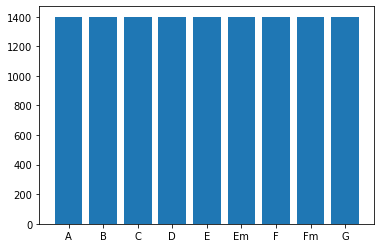

In [13]:
from sklearn.utils.class_weight import compute_class_weight
cls_train = train_generator.classes
from collections import OrderedDict
classes = list(train_generator.class_indices.keys())
num_values = []
unique, counts = np.unique(cls_train, return_counts=True)
valdict=OrderedDict(zip(unique, counts))
for i in range(9):
    num_values.append(valdict[i])
plt.figure()
x = np.arange(len(num_values))
xlabel = classes
plt.bar(x, num_values)
plt.xticks(x, xlabel)
plt.show()   

In [15]:
pretrained_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False)

C:\Users\Binuka\AppData\Local\Continuum\anaconda3\envs\tf2.1\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 5s 1us/step


In [16]:
pretrained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
_______________________________________________________________________________

In [17]:
pretrained_model.trainable = False

In [19]:
x = pretrained_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(9, activation='softmax')(x)
model = Model(inputs=pretrained_model.input, outputs=predictions)

In [20]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=["accuracy"])

filepath="mobileNetv2_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=10, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks_list = [checkpoint, learning_rate_reduction]

steps_per_epoch = 32
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=5,
    callbacks=callbacks_list,
    epochs=10,
    verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 32 steps, validate for 5 steps
Epoch 1/10
31/32 [============================>.] - ETA: 2s - loss: 0.4281 - accuracy: 0.8649
Epoch 00001: val_loss improved from inf to 3.03303, saving model to mobileNetv2_model.h5
32/32 [==============================] - 102s 3s/step - loss: 0.4184 - accuracy: 0.8681 - val_loss: 3.0330 - val_accuracy: 0.1469
Epoch 2/10
31/32 [============================>.] - ETA: 2s - loss: 0.0694 - accuracy: 0.9803
Epoch 00002: val_loss did not improve from 3.03303
32/32 [==============================] - 94s 3s/step - loss: 0.0697 - accuracy: 0.9800 - val_loss: 3.7640 - val_accuracy: 0.1656
Epoch 3/10
31/32 [============================>.] - ETA: 2s - loss: 0.0409 - accuracy: 0.9904
Epoch 00003: val_loss did not improve from 3.03303
32/32 [==============================] - 94s 3s/step - loss: 0.0422 - accuracy: 0.9897 - val_loss: 3.

In [21]:
test_score = model.evaluate_generator(testing_generator, batch_size)

print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100)) 
print("[INFO] Loss: ",test_score[0])

Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']
[INFO] accuracy: 20.61%
[INFO] Loss:  1.7237021909095347


<h1> Fine Tuning mobileNetV2 </h1>

In [23]:
model.load_weights("mobileNetv2_model.h5")

In [24]:
pretrained_model.trainable = False
for layer in model.layers[:290]:
   layer.trainable = False
for layer in model.layers[290:]:
   layer.trainable = True

In [25]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=["accuracy"])

filepath="mobileNetV2_fine_tuned.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint, learning_rate_reduction]


steps_per_epoch = 32
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=5,
    callbacks=callbacks_list,
    epochs=10,
    verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 32 steps, validate for 5 steps
Epoch 1/10
31/32 [============================>.] - ETA: 2s - loss: 0.3741 - accuracy: 0.8856
Epoch 00001: val_loss improved from inf to 3.03303, saving model to mobileNetV2_fine_tuned.h5
32/32 [==============================] - 97s 3s/step - loss: 0.3698 - accuracy: 0.8867 - val_loss: 3.0330 - val_accuracy: 0.1469
Epoch 2/10
31/32 [============================>.] - ETA: 2s - loss: 0.3599 - accuracy: 0.8902
Epoch 00002: val_loss did not improve from 3.03303
32/32 [==============================] - 94s 3s/step - loss: 0.3590 - accuracy: 0.8902 - val_loss: 3.0330 - val_accuracy: 0.1469
Epoch 3/10
31/32 [============================>.] - ETA: 2s - loss: 0.3778 - accuracy: 0.8846
Epoch 00003: val_loss did not improve from 3.03303
32/32 [==============================] - 94s 3s/step - loss: 0.3762 - accuracy: 0.8848 - val_loss: 3.0330 - val_accuracy: 0.1469
Epoch 4/10
31/32 [==========================

In [26]:
test_score = model.evaluate_generator(testing_generator, batch_size)

print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100)) 
print("[INFO] Loss: ",test_score[0])

  ...
    to  
  ['...']
[INFO] accuracy: 13.22%
[INFO] Loss:  1.4817026751115918


<h1>Building of VGG16 Model </h1>

In [1]:
# import pertinent libraries
import os
import sys
import datetime
import glob as glob
import numpy as np
import cv2
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import SGD
import tensorflow
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
img_width, img_height = 224, 224

# folders with train dir & val dir
train_dir = 'dataset/train/'
validate_dir = 'dataset/val/'
testing_dir = 'dataset/test/'
nb_epochs = 10
batch_size = 32
nb_classes = 9

# get number of images in training directory
nb_train_samples = 0
for r, dirs, files in os.walk(train_dir):
    for dr in dirs:
        nb_train_samples += len(glob.glob(os.path.join(r, dr + "/*")))
# get number of images in validation directory
nb_validate_samples = 0
for r, dirs, files in os.walk(validate_dir):
    for dr in dirs:
        nb_validate_samples += len(glob.glob(os.path.join(r, dr + "/*")))
        
print("nb_train_samples", nb_train_samples)      
print("nb_validate_samples", nb_validate_samples)

nb_train_samples 12600
nb_validate_samples 3600


In [4]:
# data pre-processing for training
train_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

# data pre-processing for validation
validate_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [5]:
# generate and store training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

# generate and store validation data
validate_generator = validate_datagen.flow_from_directory(
    validate_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 12600 images belonging to 9 classes.
Found 3600 images belonging to 9 classes.


In [12]:
# set up transfer learning on pre-trained ImageNet VGG16 model - remove fully connected layer and replace
# with softmax for classifying the number of classes in the dataset
vgg16_model = VGG16(weights = 'imagenet', include_top = False)
x = vgg16_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(nb_classes, activation = 'softmax')(x)
model = Model(input = vgg16_model.input, output = predictions)

C:\Users\Binuka\AppData\Local\Continuum\anaconda3\envs\tf2.1\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [13]:
# freeze all layers of the pre-trained InceptionV3 model
for layer in vgg16_model.layers:
    layer.trainable = False

In [14]:
# compile the new model using a RMSProp optimizer
model.compile(optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

In [15]:
# fit the model, log the results and the training time
now = datetime.datetime.now
t = now()
transfer_learning_history = model.fit_generator(
    train_generator,
    nb_epoch = nb_epochs,
    steps_per_epoch = nb_train_samples/batch_size,
    validation_data = validate_generator,
    validation_steps = nb_validate_samples/batch_size,
    class_weight='auto')
print('Training time: %s' % (now() - t))

C:\Users\Binuka\AppData\Local\Continuum\anaconda3\envs\tf2.1\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Binuka\AppData\Local\Continuum\anaconda3\envs\tf2.1\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., steps_per_epoch=393.75, validation_data=<keras.pre..., validation_steps=112.5, class_weight="auto", epochs=10)`
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/10
394/393 [==============================] - 1235s 3s/step - loss: 0.9563 - accuracy: 0.6887 - val_loss: 0.4769 - val_accuracy: 0.8442
Epoch 2/10
394/393 [==============================] - 1222s 3s/step - loss: 0.3511 - accuracy: 0.8887 - val_loss: 0.3914 - val_accuracy: 0.8853
Epoch 3/10
394/393 [==============================] - 1226s 3s/step - loss: 0.2280 - accuracy: 0.9257 - val_loss: 0.2041 - val_accuracy: 0.9539
Epoch 4/10
394/393 [==============================] - 1222s 3s/step - loss: 0.1712 - accuracy: 0.9444 - val_loss: 0.1113 - val_accuracy: 0.9314
Epoch 5/10
394/393 [==============================] - 1222s 3s/step - loss: 0.1508 - accuracy: 0.9513 - val_loss: 0.0233 - val_accuracy: 0.9611
Epoch 6/10
394/393 [==============================] - 1225s 3s/step - loss: 0.1342 - accuracy: 0.9556 - val_loss: 0.3546 - val_accuracy: 0.9431
Epoch 7/10
394/393 [==============================] - 1223s 3s/step - loss: 0.1160 - accuracy: 0.9617 - val_loss: 0.1212 - val_accuracy:

In [ ]:
# evaluate the performance the new model and report the results
score = model.evaluate_generator(validate_generator, nb_validate_samples/batch_size)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

In [ ]:
# save transfer learning model for offline prediction purposes
model.save('VGG16_model.h5')

<h1>Building of VGG19 Model </h1>

In [1]:
# import pertinent libraries
import os
import sys
import datetime
import glob as glob
import numpy as np
import cv2
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import SGD
import tensorflow
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [5]:
# set up transfer learning on pre-trained ImageNet VGG16 model - remove fully connected layer and replace
# with softmax for classifying the number of classes in the dataset
vgg19_model = VGG19(weights = 'imagenet', include_top = False)
x = vgg19_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(nb_classes, activation = 'softmax')(x)
model = Model(input = vgg19_model.input, output = predictions)

80142336/80134624 [==============================] - 25s 0us/step


C:\Users\Binuka\AppData\Local\Continuum\anaconda3\envs\tf2.1\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [6]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [7]:
# freeze all layers of the pre-trained InceptionV3 model
for layer in vgg19_model.layers:
    layer.trainable = False

In [8]:
# compile the new model using a RMSProp optimizer
model.compile(optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

In [10]:
# fit the model, log the results and the training time
now = datetime.datetime.now
t = now()
transfer_learning_history = model.fit_generator(
    train_generator,
    nb_epoch = nb_epochs,
    steps_per_epoch = nb_train_samples/batch_size,
    validation_data = validate_generator,
    validation_steps = nb_validate_samples/batch_size,
    class_weight='auto')
print('Training time: %s' % (now() - t))
# save transfer learning model for offline prediction purposes
model.save('VGG19_model.h5')

C:\Users\Binuka\AppData\Local\Continuum\anaconda3\envs\tf2.1\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Binuka\AppData\Local\Continuum\anaconda3\envs\tf2.1\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., steps_per_epoch=393.75, validation_data=<keras.pre..., validation_steps=112.5, class_weight="auto", epochs=10)`
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/10
394/393 [==============================] - 1438s 4s/step - loss: 1.1144 - accuracy: 0.6166 - val_loss: 0.5688 - val_accuracy: 0.7914
Epoch 2/10
394/393 [==============================] - 1445s 4s/step - loss: 0.4596 - accuracy: 0.8507 - val_loss: 0.2870 - val_accuracy: 0.9133
Epoch 3/10
394/393 [==============================] - 1426s 4s/step - loss: 0.3167 - accuracy: 0.8942 - val_loss: 0.5951 - val_accuracy: 0.7467
Epoch 4/10
394/393 [==============================] - 1423s 4s/step - loss: 0.2477 - accuracy: 0.9162 - val_loss: 0.3819 - val_accuracy: 0.9233
Epoch 5/10
394/393 [==============================] - 1439s 4s/step - loss: 0.2165 - accuracy: 0.9254 - val_loss: 0.3410 - val_accuracy: 0.9103
Epoch 6/10
394/393 [==============================] - 1429s 4s/step - loss: 0.1944 - accuracy: 0.9364 - val_loss: 0.0436 - val_accuracy: 0.9606
Epoch 7/10
394/393 [==============================] - 1424s 4s/step - loss: 0.1750 - accuracy: 0.9406 - val_loss: 0.5339 - val_accuracy:

In [11]:
# evaluate the performance the new model and report the results
score = model.evaluate_generator(validate_generator, nb_validate_samples/batch_size)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.023434581235051155
Test Accuracy: 0.9313889145851135


In [16]:
from scipy.interpolate import make_interp_spline

Text(0.5, 1.0, 'Loss Curves')

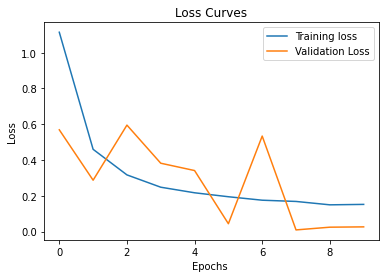

In [21]:
#Plot the Graph

# Loss Curves
plt.plot(transfer_learning_history.history['loss'])
plt.plot(transfer_learning_history.history['val_loss'])
plt.legend(['Training loss', 'Validation Loss'])
plt.xlabel('Epochs ')
plt.ylabel('Loss')
plt.title('Loss Curves')

Text(0.5, 1.0, 'Accuracy Curves')

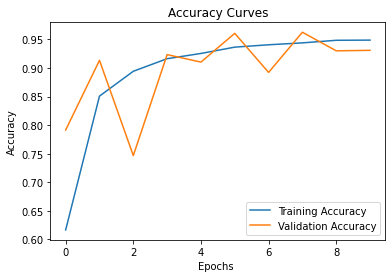

In [23]:
# Accuracy Curves
# plt.figure(figsize=[8,6])
plt.plot(transfer_learning_history.history['accuracy'])
plt.plot(transfer_learning_history.history['val_accuracy'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs ')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')

<h1>Building of Xception Model </h1>

In [1]:
import os
import sys
import datetime
import glob as glob
import numpy as np
import cv2
import keras
from keras.applications.xception import Xception, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import SGD
import tensorflow
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

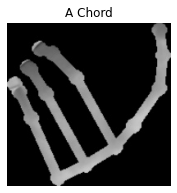

In [13]:
img = load_img('dataset/train/A/45.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('A Chord')
plt.show()

In [6]:
x = img_to_array(img)
x2 = x.reshape((1,) + x.shape)

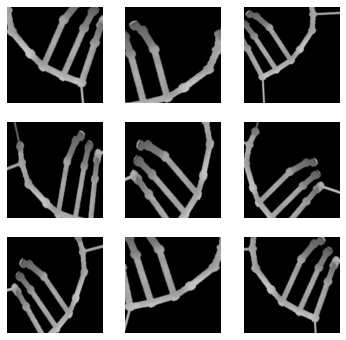

In [9]:
i = 0
fig = plt.figure(figsize = (6,6))
plt.title('Pre-processed')
for batch in datagen.flow(x2, batch_size = 1):
    i += 1
    if i > 9:
        break
    temp = batch.reshape(x.shape)
    plt.subplot(3, 3, i)
    plt.imshow(temp.astype('uint8'))
    plt.axis('off')
plt.show()

In [3]:
img_width, img_height = 299, 299

# folders with train dir & val dir
train_dir = 'dataset/train/'
validate_dir = 'dataset/val/'
testing_dir = 'dataset/test/'
nb_epochs = 10
batch_size = 32
nb_classes = 9

# get number of images in training directory
nb_train_samples = 0
for r, dirs, files in os.walk(train_dir):
    for dr in dirs:
        nb_train_samples += len(glob.glob(os.path.join(r, dr + "/*")))
# get number of images in validation directory
nb_validate_samples = 0
for r, dirs, files in os.walk(validate_dir):
    for dr in dirs:
        nb_validate_samples += len(glob.glob(os.path.join(r, dr + "/*")))
        
print("nb_train_samples", nb_train_samples)      
print("nb_validate_samples", nb_validate_samples)

nb_train_samples 12600
nb_validate_samples 3600


In [6]:
# set up transfer learning on pre-trained ImageNet Xception model - remove fully connected layer and replace
# with softmax for classifying 10 classes
xcep_model = Xception(weights = 'imagenet', include_top = False)
x = xcep_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(nb_classes, activation = 'softmax')(x)
model = Model(input = xcep_model.input, output = predictions)

83689472/83683744 [==============================] - 24s 0us/step


C:\Users\Binuka\AppData\Local\Continuum\anaconda3\envs\tf2.1\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [ ]:
# freeze all layers of the pre-trained InceptionV3 model
for layer in vgg19_model.layers:
    layer.trainable = False

In [ ]:
# compile the new model using a RMSProp optimizer
model.compile(optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

In [7]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [ ]:
# fit the model, log the results and the training time
now = datetime.datetime.now
t = now()
transfer_learning_history = model.fit_generator(
    train_generator,
    nb_epoch = nb_epochs,
    steps_per_epoch = nb_train_samples/batch_size,
    validation_data = validate_generator,
    validation_steps = nb_validate_samples/batch_size,
    class_weight='auto')
print('Training time: %s' % (now() - t))
# save transfer learning model for offline prediction purposes
model.save('xception_model.h5')

In [ ]:
# evaluate the performance the new model and report the results
score = model.evaluate_generator(validate_generator, nb_validate_samples/batch_size)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

<h1> Implementation of the OpenCV frame with MediaPipe </h1>

In [1]:
import cv2
import mediapipe as mp
from keras.models import load_model
import numpy as np
from google.protobuf.json_format import MessageToDict

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

# keypoint_connections = [(0, 1), (0, 13), (1, 5), (5, 9), (9, 13), (1, 2), (2, 3), (3, 4), (5, 6),
#                         (6, 7), (7, 8), (9, 10), (10, 11), (11, 12), (13, 14), (14, 15), (15, 16)]

keypoint_connections = [(0, 4), (4, 8), (8, 12), (0, 1), (1, 2), (2, 3), (4, 5),
                        (5, 6), (6, 7), (8, 9), (9, 10), (10, 11), (12, 13), (13, 14), (14, 15)]

model = load_model('VGG19_model.h5')
# chord_dict = {0: 'A', 1: 'B', 2: 'C', 3: 'Cm', 4: 'D', 5: 'E', 6: 'Em', 7: 'F', 8: 'Fm', 9: 'G'}
chord_dict = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'Em', 6: 'F', 7: 'Fm', 8: 'G'}

# The little square showing the current chord will be 80 x 80
legend_size = 80
W = 640
center_column = W // 2 - legend_size // 2

keypoint_color = (255, 255, 255)
line_color = (255, 255, 255)

def rescale_frame(frame, percent=75):
    width = int(frame.shape[1] * percent / 100)
    height = int(frame.shape[0] * percent / 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation=cv2.INTER_AREA)


image_x, image_y = 200, 200

cap = cv2.VideoCapture(1)

width  = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
textposition = (10,int(height) - 20)

def main():
    hands = mp_hands.Hands(
        min_detection_confidence=0.7, min_tracking_confidence=0.7)

    pic_no = 0
    flag_start_capturing = False
    frames = 0

    while cap.isOpened():
        ret, image = cap.read()
        img_y, img_x, _ = image.shape
        image = cv2.flip(image, 1)
        image_orig = cv2.flip(image, 1)
        image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        results_hand = hands.process(image)
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results_hand.multi_hand_landmarks:
            for hand_landmarks in results_hand.multi_hand_landmarks:
                landmarks = MessageToDict(hand_landmarks)["landmark"]
                # landmarks.pop(1)
                # landmarks.pop(2)
                # landmarks.pop(2)
                # landmarks.pop(1)
                landmarks.pop(0)
                landmarks.pop(0)
                landmarks.pop(1)
                landmarks.pop(1)
                landmarks.pop(0)
                decoded_landmarks = []

                for l in landmarks:
                    x, y = int(l['x'] * img_x), int(l['y'] * img_y)
                    decoded_landmarks.append({'x': x, 'y': y})

                for l in decoded_landmarks:
                    cv2.circle(image, (l['x'], l['y']), 5, keypoint_color, 5)

                for c in keypoint_connections:
                    cv2.line(image, (decoded_landmarks[c[0]]['x'], decoded_landmarks[c[0]]['y']),
                            (decoded_landmarks[c[1]]['x'], decoded_landmarks[c[1]]['y']), line_color, 10)

        res = cv2.bitwise_and(image, cv2.bitwise_not(image_orig))

        gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
        ret, th1 = cv2.threshold(gray, 25, 255, cv2.THRESH_BINARY)
        contours, hierarchy = cv2.findContours(th1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if len(contours) > 0:
            contours = sorted(contours, key=cv2.contourArea)
            contour = contours[-1]
            x1, y1, w1, h1 = cv2.boundingRect(contour)
            # cv2.rectangle(image, (x1, y1), (x1 + w1, y1 + h1), (0, 255, 0), 2)
            save_img = gray[y1:y1 + h1, x1:x1 + w1]
            save_img = cv2.resize(save_img, (image_x, image_y))
            pred_probab, pred_class = keras_predict(model, save_img)
#             print(pred_class, pred_probab)
            
            chord_legend = cv2.imread("CaptureLabel/%s.jpg" % chord_dict[pred_class], cv2.IMREAD_COLOR)    
            image[0:legend_size, W - legend_size - center_column:W - legend_size - center_column + legend_size] = chord_legend
    
            cv2.putText(image, "Predicted chord: %s "% chord_dict[pred_class] , textposition, cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 255), 2)
#             cv2.putText(image, str(chord_dict[pred_class]), (x1 + 50, y1 - 50), cv2.FONT_HERSHEY_SIMPLEX, 7,
#                         (255, 0, 0), 9)
            keypress = cv2.waitKey(1)
            if keypress == ord('c'):
                break
#             image = rescale_frame(image, percent=75)
            cv2.imshow("Img", image)

    hands.close()
    cap.release()


def keras_predict(model, image):
    processed = keras_process_image(image)
    pred_probab = model.predict(processed)[0]
    pred_class = list(pred_probab).index(max(pred_probab))
    return max(pred_probab), pred_class


def keras_process_image(img):
    img = cv2.resize(img, (image_x, image_y))
    img = np.array(img, dtype=np.float32)
    img = np.reshape(img, (-1, image_x, image_y, 1))
    return img


main()

Using TensorFlow backend.


ValueError: cannot reshape array of size 40000 into shape (200,200,3)

In [12]:
if __name__ == "__main__":
    app.run(host="localhost", port=8000)

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://localhost:8000 (Press CTRL+C to quit)
127.0.0.1 - - [28/Jun/2022 21:53:23] "GET / HTTP/1.1" 200 -
[2022-06-28 21:53:23,188] ERROR in app: Exception on /video_feed [GET]
Traceback (most recent call last):
  File "C:\Users\Binuka\AppData\Local\Continuum\anaconda3\envs\tf2.1\lib\site-packages\flask\app.py", line 2077, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Users\Binuka\AppData\Local\Continuum\anaconda3\envs\tf2.1\lib\site-packages\flask\app.py", line 1525, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\Users\Binuka\AppData\Local\Continuum\anaconda3\envs\tf2.1\lib\site-packages\flask\app.py", line 1523, in full_dispatch_request
    rv = self.dispatch_request()
  File "C:\Users\Binuka\AppData\Local\Continuum\anaconda3\envs\tf2.1\lib\site-packages\flask\app.py", line 1509, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "C:\Users\Binuka\AppData\Local\Temp\i

In [ ]:
vid.release()